In [1]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from dyn_cnn import DynCNN
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

import cPickle as pickle
import os
import mahotas as mh
import numpy as np
import time

import mlproof as mlp


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
with open('/home/d/nets/MergeNet_cylinder1_larger_border_overlap_usevars/net.p', 'rb') as f:
    cnn = pickle.load(f)

In [3]:
with open('/home/d/dojo_xp/data/bigM_cylinder_250_300.p', 'rb') as f:
    m_s = pickle.load(f)

In [4]:
# load data as volume
volume = []
volume_prob = []
volume_segmentation = []
volume_groundtruth = []
for z in range(250, 300):
    image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
    
    volume.append(image)
    volume_prob.append(prob)
    volume_segmentation.append(rhoana)
    volume_groundtruth.append(gold)

Loading z00000250.png
Loading z00000251.png
Loading z00000252.png
Loading z00000253.png
Loading z00000254.png
Loading z00000255.png
Loading z00000256.png
Loading z00000257.png
Loading z00000258.png
Loading z00000259.png
Loading z00000260.png
Loading z00000261.png
Loading z00000262.png
Loading z00000263.png
Loading z00000264.png
Loading z00000265.png
Loading z00000266.png
Loading z00000267.png
Loading z00000268.png
Loading z00000269.png
Loading z00000270.png
Loading z00000271.png
Loading z00000272.png
Loading z00000273.png
Loading z00000274.png
Loading z00000275.png
Loading z00000276.png
Loading z00000277.png
Loading z00000278.png
Loading z00000279.png
Loading z00000280.png
Loading z00000281.png
Loading z00000282.png
Loading z00000283.png
Loading z00000284.png
Loading z00000285.png
Loading z00000286.png
Loading z00000287.png
Loading z00000288.png
Loading z00000289.png
Loading z00000290.png
Loading z00000291.png
Loading z00000292.png
Loading z00000293.png
Loading z00000294.png
Loading z0

In [5]:
new_m_s, out_volume, fixes, vi_s30mins = Fixer.splits_global_from_M(cnn, m_s, 
                                                 volume, 
                                                 volume_prob, 
                                                 volume_segmentation, 
                                                 volume_groundtruth,
                                                 hours=-1)

30 minutes done bigM_max= 1.0
60 minutes done bigM_max= 0.999999761581
90 minutes done bigM_max= 0.999997615814
120 minutes done bigM_max= 0.999985098839
150 minutes done bigM_max= 0.999943971634
180 minutes done bigM_max= 0.999823331833
210 minutes done bigM_max= 0.999594569206
240 minutes done bigM_max= 0.999058306217
270 minutes done bigM_max= 0.999300956726
300 minutes done bigM_max= 0.996120750904
330 minutes done bigM_max= 0.992333889008
360 minutes done bigM_max= 0.999994874001
390 minutes done bigM_max= 0.999183356762
420 minutes done bigM_max= 0.992689192295
450 minutes done bigM_max= 0.942699432373
480 minutes done bigM_max= 0.907107234001
510 minutes done bigM_max= 0.856339633465
540 minutes done bigM_max= 0.797009646893
570 minutes done bigM_max= 0.914630949497
600 minutes done bigM_max= 0.609803557396
630 minutes done bigM_max= 0.49153932929
660 minutes done bigM_max= 0.378842830658
690 minutes done bigM_max= 0.246702998877
720 minutes done bigM_max= 0.154804095626
750 min

In [6]:
len(fixes)

33039

In [35]:
from collections import Counter
good_fixes_per_minute = []
bad_fixes_per_minute = []
    
for f in range(0,len(fixes),12):
    counts = Counter(fixes[f:f+12])
    good_counts = counts['Good']
    bad_counts = counts['Bad']
    good_fixes_per_minute.append(good_counts)
    bad_fixes_per_minute.append(bad_counts)

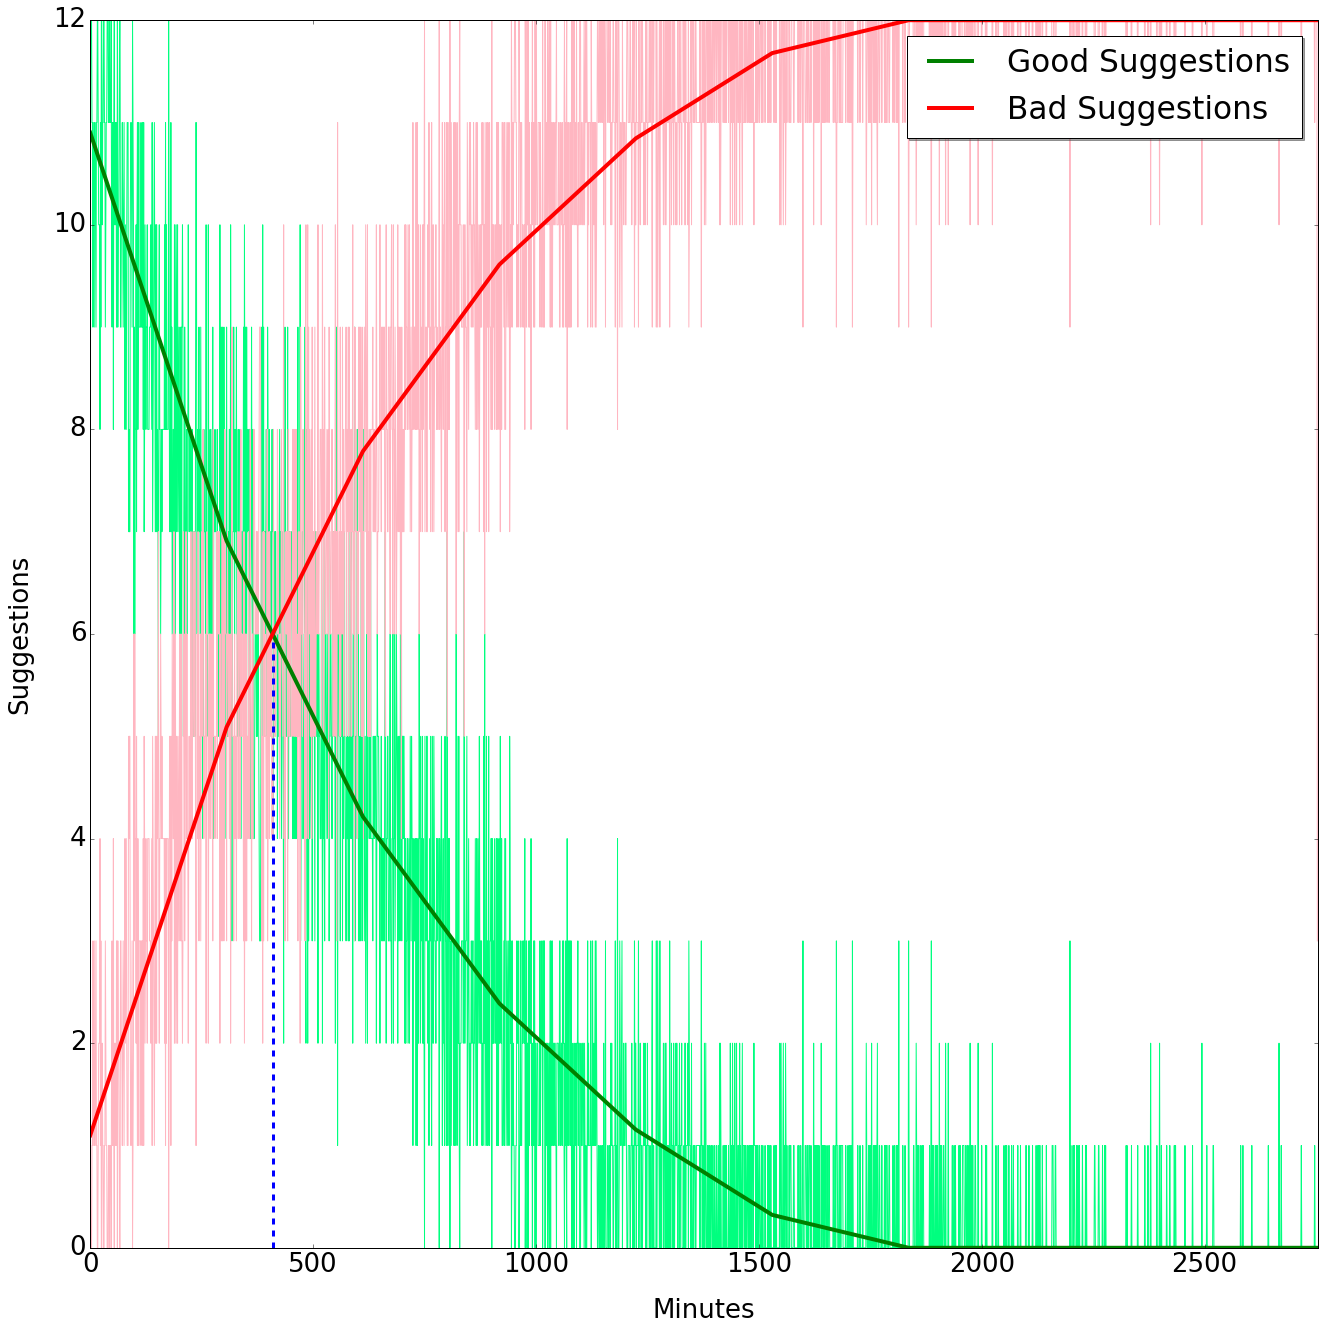

In [99]:
fig, ax = plt.subplots(figsize=(22,22))




x_marks = range(len(good_fixes_per_minute))

def green_func(x, a, b, c):
    ddd = a*np.exp(-b*x)+c
    return np.clip(ddd, 0, 12)
    
def red_func(x, a, b, c):
    ddd = 1-a*np.exp(-b*x)+c
    return np.clip(ddd, 0, 12)


popt, _ = curve_fit(green_func, x_marks, good_fixes_per_minute, p0=(1, 1e-6, 1))
goodx = np.linspace(0,len(good_fixes_per_minute),10)
goody = green_func(goodx, *popt)
popt2, _ = curve_fit(red_func, x_marks, bad_fixes_per_minute, p0=(1, 1e-6, 1))
bady = red_func(goodx, *popt2)


ax.plot(x_marks, good_fixes_per_minute, 'springgreen', linewidth=1)
ax.plot(x_marks, bad_fixes_per_minute ,'lightpink', linewidth=1)


ax.axvline(x=409, ymin=0, ymax=.5, color='b', linestyle='dashed', linewidth=3)
ax.plot(goodx, goody, 'g', linewidth=4, label='Good Suggestions')
ax.plot(goodx, bady, 'r', linewidth=4, label='Bad Suggestions')


# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Suggestions', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(good_fixes_per_minute)])

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='upper right', shadow=True)
plt.savefig('/home/d/Projects/em-quality-metric/Paper/gfx/suggestions_good_bad_simuser.pdf')

# plt.plot()
plt.show()

In [9]:
from scipy.optimize import curve_fit

In [11]:
initial_vis = []
for z in range(len(volume)):
    vi = Util.vi(volume_groundtruth[z], volume_segmentation[z])
    initial_vis.append(vi)

In [12]:
proofread_vis = [initial_vis] + vi_s30mins

In [15]:
median_vis_30_mins = []
for i,vi in enumerate(proofread_vis):
#     if i % 12 == 0:
        median_vis_30_mins.append(np.mean(vi))
median_vis_per_min = []
for m in median_vis_30_mins:
    for i in range(30):
        median_vis_per_min.append(m)

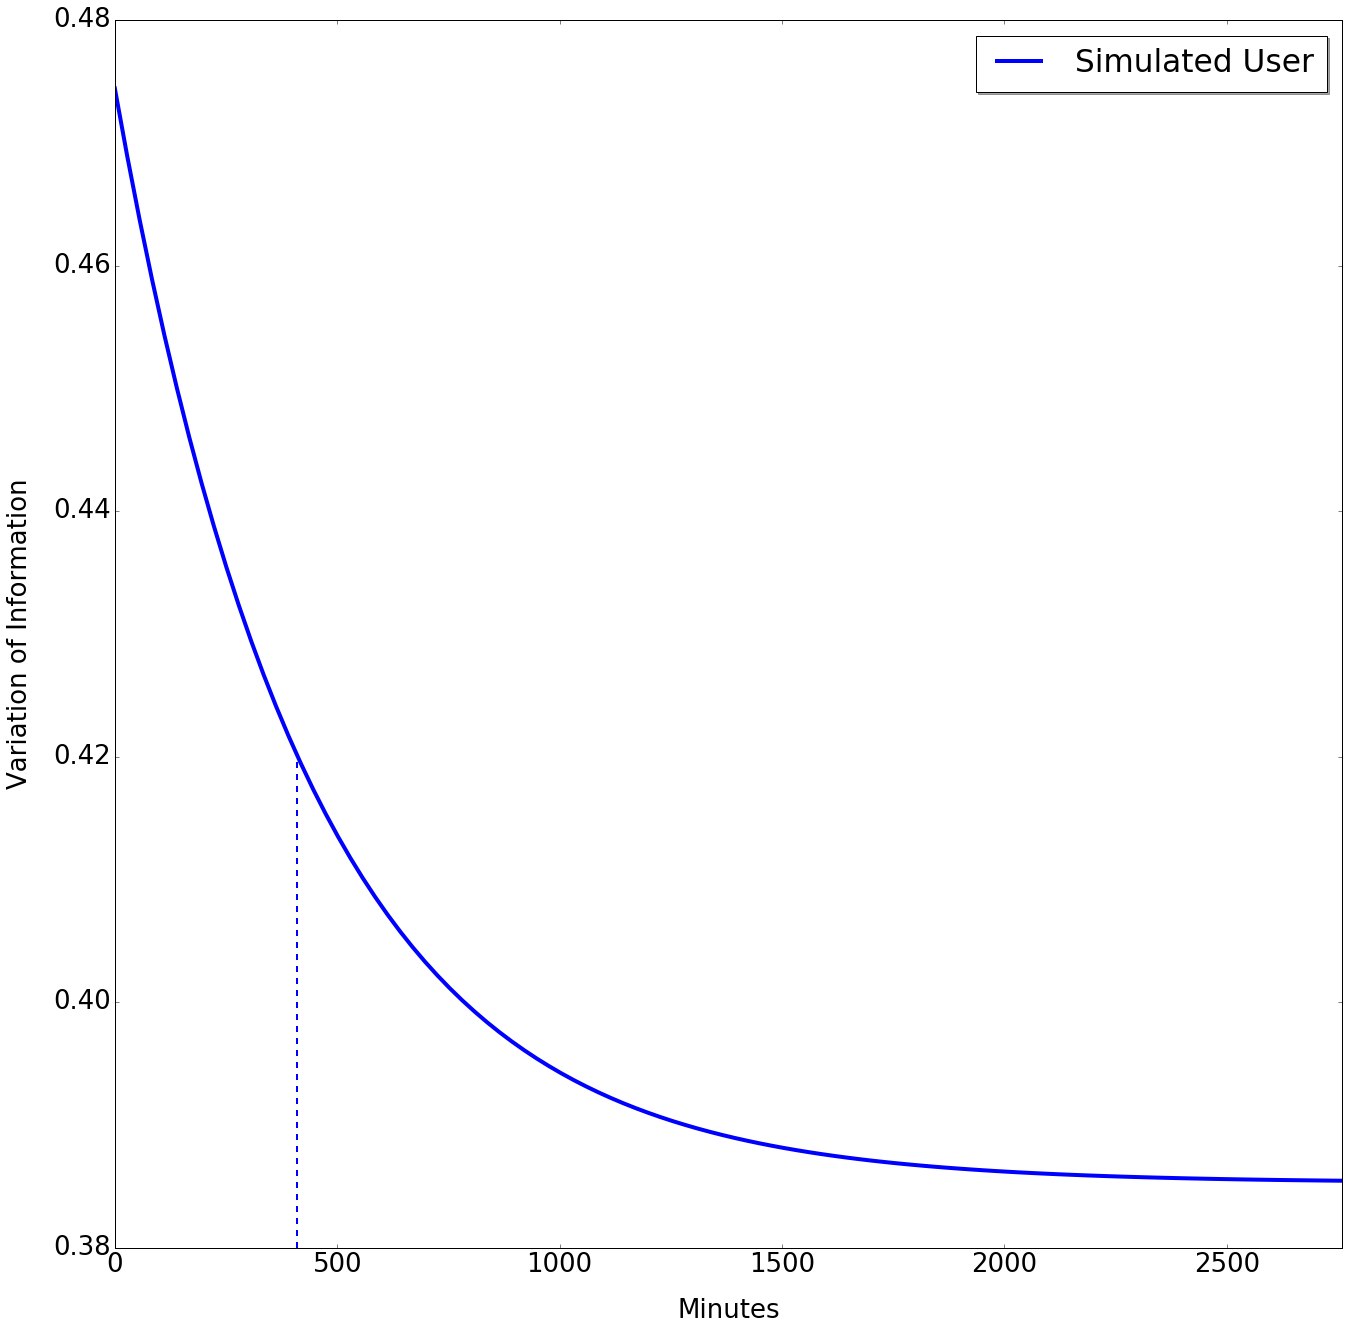

In [100]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(median_vis_per_min))

popt, _ = curve_fit(green_func, x_marks, median_vis_per_min)

xx = np.linspace(0,len(median_vis_per_min),100)
mediany = green_func(xx, *popt)

# ax.plot(x_marks, median_vis_per_min, 'r', label='Simulated User')

ax.plot(xx, mediany, linewidth=4, label='Simulated User')
ax.axvline(x=409, ymin=0, ymax=.4, color='b', linestyle='dashed', linewidth=2)

plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(median_vis_per_min)])
# plt.ylim([0.4,0.5])


legend = ax.legend(loc='upper right', shadow=True)

font = {'family' : 'normal',
        'size'   : 26}

plt.rc('font', **font)
plt.savefig('/home/d/Projects/em-quality-metric/Paper/gfx/simuser_vi.pdf')

plt.show()

In [30]:
vi_s30mins[-1]

[0.2996385520058764,
 0.30717528612158684,
 0.3172611975136528,
 0.3078792680833038,
 0.3071961470724087,
 0.30225549904304927,
 0.31959331348024733,
 0.3628710688480865,
 0.33047943433179405,
 0.5040062340173037,
 0.4942491353003078,
 0.49319863837169287,
 0.5074663136844872,
 0.4883546756409203,
 0.4854514665744958,
 0.4911826098923431,
 0.48232239900671203,
 0.4429087935387086,
 0.3994317664973668,
 0.31895033502457526,
 0.35210929379604927,
 0.3249672984730161,
 0.3385556168516519,
 0.369511261435167,
 0.33977850488584593,
 0.39013224624070464,
 0.38827187411610886,
 0.42151692426842935,
 0.42353759111366784,
 0.4452147792353829,
 0.40633629801480886,
 0.33474674485644407,
 0.4125551191054484,
 0.40188378328308794,
 0.4356138293973375,
 0.376681985684292,
 0.3895786890362798,
 0.4473386109103954,
 0.48735053568718456,
 0.4381909207373962,
 0.41931436918489773,
 0.40859252085862163,
 0.4027733467955823,
 0.438174001125625,
 0.42461390405202515,
 0.3882032229360588,
 0.34927000642045

In [40]:
counts = Counter(fixes)
good_counts = counts['Good']
bad_counts = counts['Bad']

In [39]:
good_counts

6320

In [41]:
bad_counts

26719

In [42]:
len(fixes)

33039

In [55]:
good_counts_left_per_minute = []
bad_counts_left_per_minute = []
good_counts_left = good_counts
bad_counts_left = bad_counts
for i,f in enumerate(fixes):
    fixes_per_min = fixes[i*12:i*12+12]
    counts_per_min = Counter(fixes_per_min)
    good_counts_per_min = counts_per_min['Good']
    good_counts_left = good_counts_left-good_counts_per_min
    good_counts_left_per_minute.append(good_counts_left)
    
    bad_counts_per_min = counts_per_min['Bad']
    bad_counts_left = bad_counts_left-bad_counts_per_min
    bad_counts_left_per_minute.append(bad_counts_left)

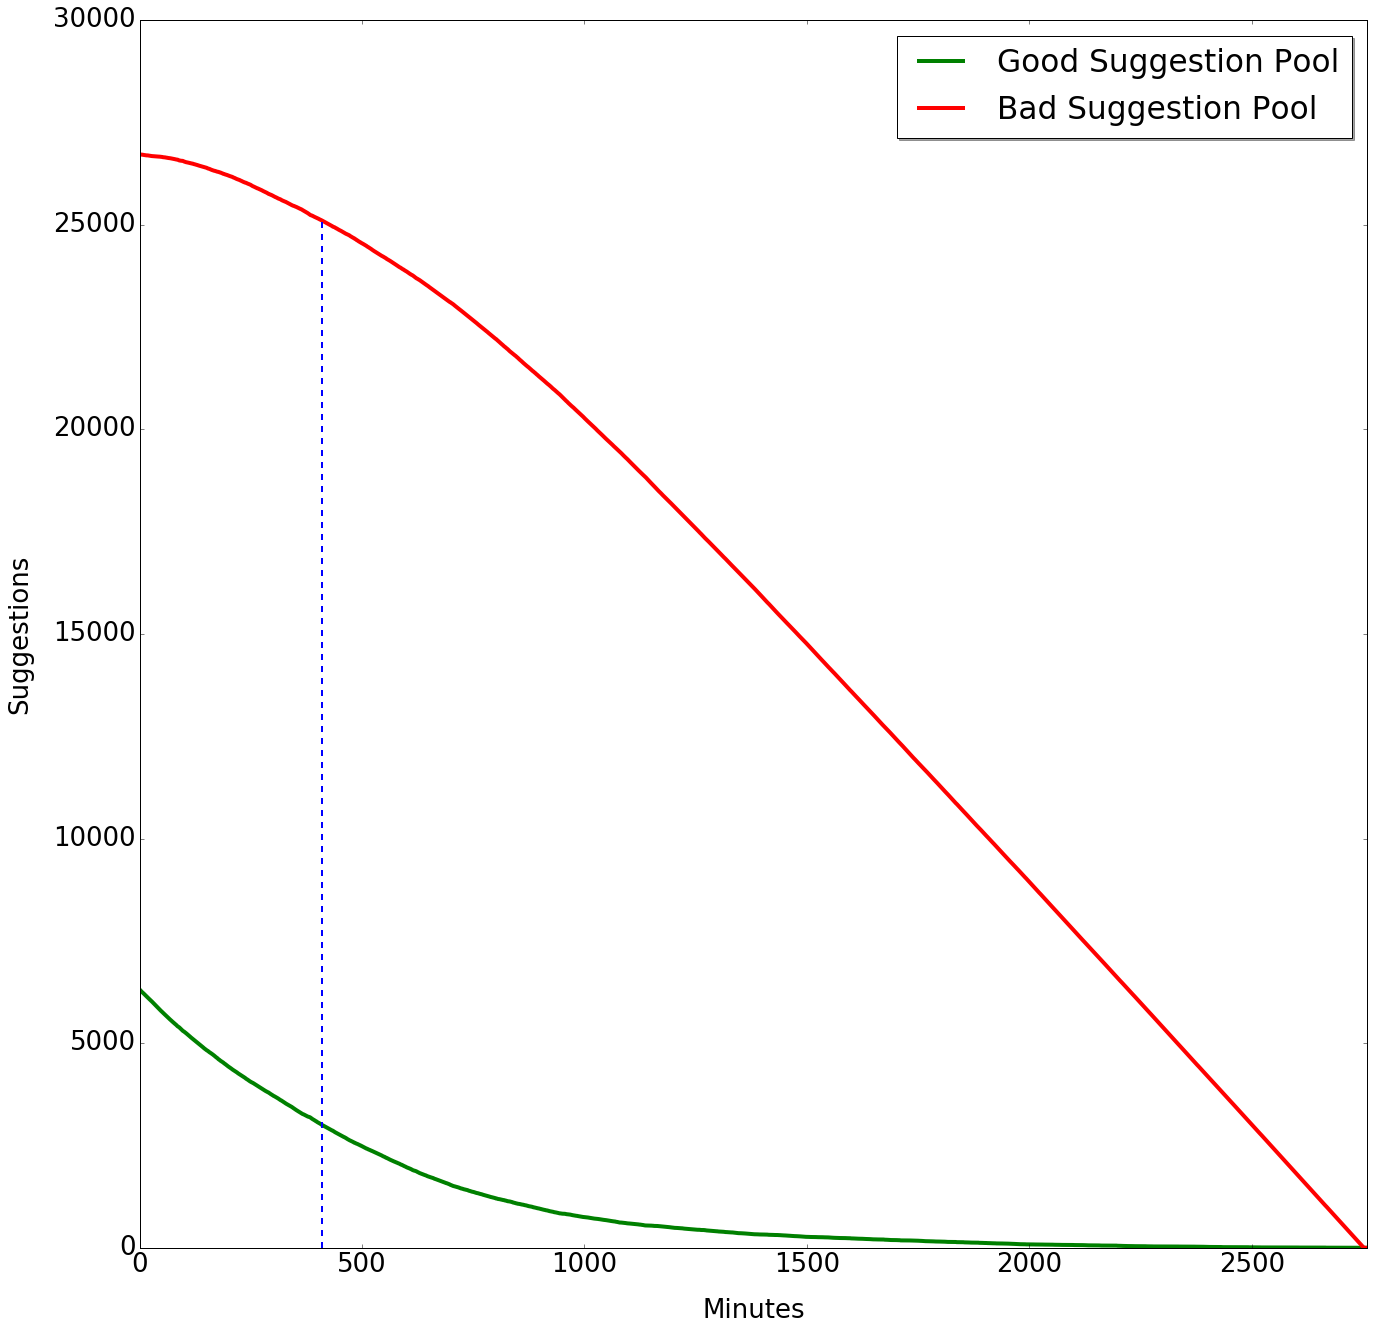

In [108]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(good_counts_left_per_minute))

# popt, _ = curve_fit(green_func, x_marks, median_vis_per_min)

# xx = np.linspace(0,len(median_vis_per_min),100)
# mediany = green_func(xx, *popt)

ax.plot(x_marks, good_counts_left_per_minute, 'g', linewidth=4, label='Good Suggestion Pool')
ax.plot(x_marks, bad_counts_left_per_minute, 'r', linewidth=4, label='Bad Suggestion Pool')


# ax.plot(xx, mediany, linewidth=4, label='Simulated User')
ax.axvline(x=409, ymin=0, ymax=.84, color='b', linestyle='dashed', linewidth=2)

plt.ylabel('Suggestions', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(median_vis_per_min)])
# plt.ylim([0.4,0.5])


legend = ax.legend(loc='upper right', shadow=True)

font = {'family' : 'normal',
        'size'   : 26}

plt.rc('font', **font)
plt.savefig('/home/d/Projects/em-quality-metric/Paper/gfx/suggestion_pool.pdf')
plt.show()

In [62]:
m = np.zeros((len(fixes),3), dtype=np.uint8)
for i,f in enumerate(fixes):
    if f == 'Good':
        m[i] = (0,255,0)
    else:
        m[i] = (255,0,0)

In [63]:
m.shape

(33039, 3)

In [64]:
np.sqrt(33039)

181.76633351641331

In [89]:
m_new = m[0:180*180].reshape(324,100,3)

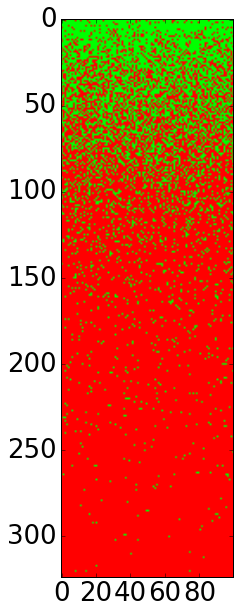

In [90]:
Util.view((m_new), color=False, large=True)

In [68]:
409*12

4908

In [91]:
4908/100

49

In [94]:
m_new = m[0:4900].reshape(70,70,3)

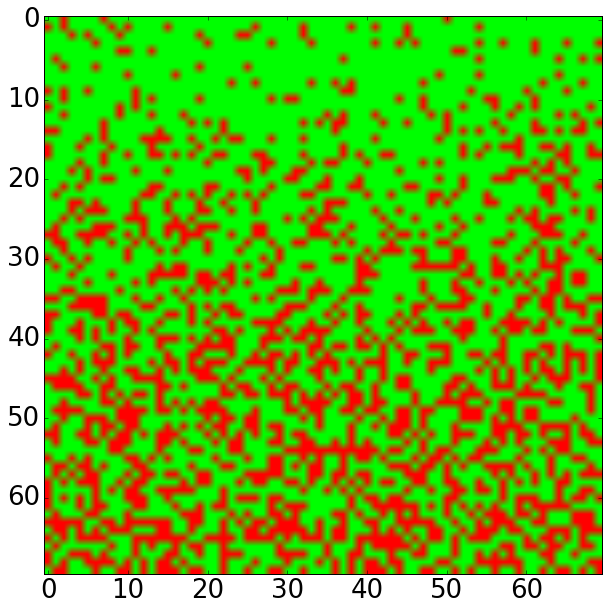

In [95]:
Util.view((m_new), color=False, large=True)

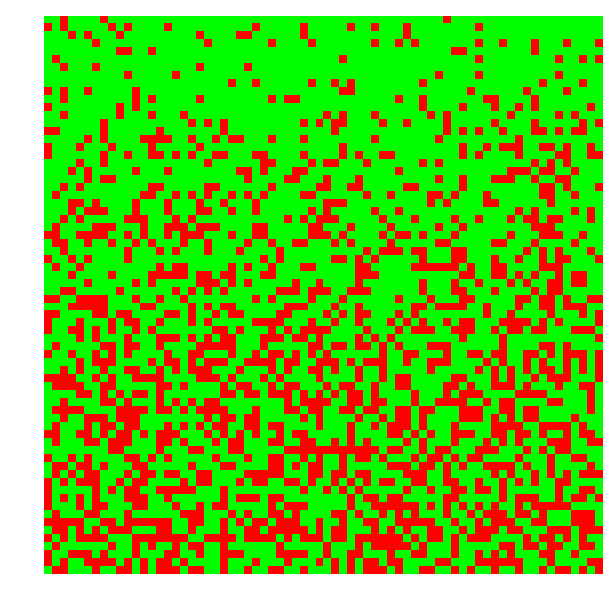

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(m_new,interpolation='nearest')
# fig.set_cmap('hot')
plt.axis('off')
plt.savefig('/home/d/Projects/em-quality-metric/Paper/gfx/correction_matrix.png')

In [ ]:
mh.imsave(m_new, '/home/d/Projects/em-quality-metric/Paper/gfx/cylinder_vi.pdf')